### Deep Ensamble MDN Toy Example ###

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

/Users/ermanoarruda/virtualenvs/robotics/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
import os
import copy
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from aml_dl.mdn.model.tf_ensemble_mdn_model import EnsambleMDN

from IPython import display
import time

## Configs

In [5]:
EXP_NAME = 'exp_ensemble'

check_point_dir   = os.environ['AML_DATA'] + '/aml_dl/mdn/tf_check_points/exp_ensemble/'
summary_dir = os.environ['AML_DATA'] + '/aml_dl/mdn/summaries/exp_ensemble/'

if not os.path.exists(check_point_dir):
    os.makedirs(check_point_dir)

if not os.path.exists(summary_dir):
    os.makedirs(summary_dir)

adam_params = {
    'type': 'adam',
    'params': {'learning_rate' : 0.0025, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'use_locking': False}
}

network_params = {
    'n_ensembles': 1,
    'dim_input': 1, 
    'dim_output': 1,
    'n_hidden': 25,
    'k_mixtures': 1,
    'write_summary': False,
    'load_saved_model': False,
    'model_dir': check_point_dir + '/inv/',
    'model_name':'ensemble_model_inv_10_kernels.ckpt',
    'optimiser': adam_params,
    'summary_dir':summary_dir+'/inv/',
    'device': '/cpu:0',
}

In [6]:
ensamble_mdn = EnsambleMDN(network_params)

In [7]:
ensamble_mdn._init_model()

## Prepare data

In [8]:
def fun_h(t, noise_gain=0.):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
    return np.cos(2*t - 1/2)/2 + np.cos(t)/2 - 1 + noise

def fun_poly(t, noise_gain=0.):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
    return -0.001*(t ** 3) + np.square(t)*0.01

def fun_g(r, noise_gain=0.):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
    noise = noise_gain*np.random.randn(d1, d2)
    return np.divide(np.power(np.multiply((np.sin(r) - np.sin(2*r)/2 + np.sin(3*r)/3. - 
                                           np.sin(4*r)/4. + 4),r),2),(r+1)) + noise

def sawtoothxy(x,y):
    t, r = cart2pol(x,y) # change to polar coordinates
    h = fun_h(t)
    g = fun_g(r)
    f = np.multiply(g,h)
    return f

func_y = fun_h

In [9]:
num_data_points = 30
x_values = np.linspace(0, 12, num_data_points)
y_values = func_y(x_values, 0.0)

In [10]:
num_data_points = 1000
gdx_values = np.linspace(0, 12, num_data_points)
gdy_values = func_y(gdx_values, 0.0)

In [11]:


def test_and_plot(i):
    
    x_test = gdx_values#np.linspace(0, 12, num_data_points)
    y_test = gdy_values #fun_h(x_test, 0.0)
    
    out_mus = ensamble_mdn.run_op(sess, 'mus', np.expand_dims(x_test,axis=1))
    out_sigma = ensamble_mdn.run_op(sess, 'sigmas', np.expand_dims(x_test,axis=1))
    out_pis = ensamble_mdn.run_op(sess, 'pis', np.expand_dims(x_test,axis=1))
    
    mean_out, var_out = ensamble_mdn.forward(sess, np.expand_dims(x_test,axis=1))
    
    stddev = 3.0

    fig2 = plt.figure(figsize=(10,10))
    ax = fig2.add_subplot(111)

    ypl = [float(mu-stddev*np.sqrt(sig)) for mu,sig in zip(mean_out,var_out)]
    yph = [float(mu+stddev*np.sqrt(sig)) for mu,sig in zip(mean_out,var_out)]

    ax.plot(x_test, y_test, color='r')

    ax.fill_between(x_test.tolist(), ypl, yph, facecolor='grey', interpolate=True, alpha=0.9)
    ax.plot(x_test, mean_out, color='b', linewidth=2.5)

    colours = ['g','c','k','m','y']

    for k in range(network_params['n_ensembles']):
        ax.plot(x_test, np.reshape(out_mus[k],(-1,)), color=colours[k],linewidth=0.5)

    plt.scatter(x_train,y_values)

    x_test = gdx_values#np.linspace(0, 12, num_data_points)
    y_test = gdy_values #fun_h(x_test, 0.0)
#     plt.show()
    
    plt.title('Iteration %d'%(i,))
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.01)
    

In [12]:
x_train = x_values[:,None]
y_train = y_values[:,None]

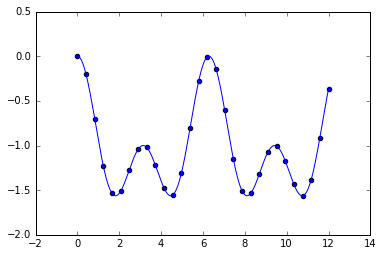

In [13]:
plt.figure()
plt.scatter(x_train,y_values)
plt.plot(gdx_values,gdy_values)
plt.show()

In [14]:
sess = tf.InteractiveSession()

In [ ]:
iterations = 1000

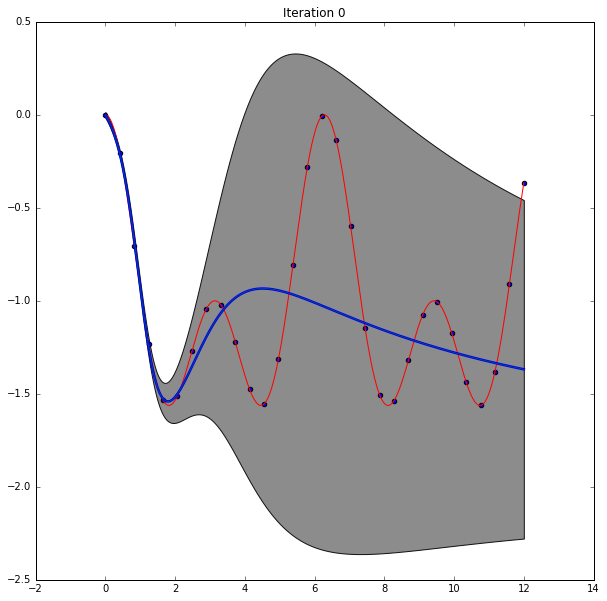

In [ ]:
for i in range(100):
    loss = ensamble_mdn.train(x_train, y_train, sess, iterations)
    test_and_plot(i)

In [ ]:
#plot loss curves
plt.figure(figsize=(15,15))
plot_no=network_params['n_ensembles']*100+11
for k in range(network_params['n_ensembles']):
    plt.subplot(plot_no)
    plt.plot(np.arange(100, iterations,1), loss[k, 100:], 'r-')
    plot_no += 1
plt.show()

## Test

In [ ]:
x_test = gdx_values#np.linspace(0, 12, num_data_points)
y_test = gdy_values #fun_h(x_test, 0.0)

In [ ]:
out_mus = ensamble_mdn.run_op(sess, 'mus', np.expand_dims(x_test,axis=1))
out_sigma = ensamble_mdn.run_op(sess, 'sigmas', np.expand_dims(x_test,axis=1))
out_pis = ensamble_mdn.run_op(sess, 'pis', np.expand_dims(x_test,axis=1))

In [ ]:
# out_mus = np.reshape(out_mus,(-1,1))
# out_sigma = np.reshape(out_sigma,(-1,1))
# out_pis = np.reshape(out_pis,(-1,1))

In [ ]:
# print np.reshape(out_mus[0],(-1,1))
# print out_sigma.shape
# print out_pis.shape

In [ ]:
y_test.shape

In [ ]:
mean_out, var_out = ensamble_mdn.forward(sess, np.expand_dims(x_test,axis=1))

In [ ]:
stddev = 3.0

fig2 = plt.figure(figsize=(10,10))
ax = fig2.add_subplot(111)

ypl = [float(mu-stddev*np.sqrt(sig)) for mu,sig in zip(mean_out,var_out)]
yph = [float(mu+stddev*np.sqrt(sig)) for mu,sig in zip(mean_out,var_out)]

ax.plot(x_test, y_test, color='r')

ax.fill_between(x_test.tolist(), ypl, yph, facecolor='grey', interpolate=True, alpha=0.9)
ax.plot(x_test, mean_out, color='b', linewidth=2.5)

colours = ['g','c','k','m','y']

for k in range(network_params['n_ensembles']):
    ax.plot(x_test, np.reshape(out_mus[k],(-1,)), color=colours[k],linewidth=0.5)

plt.scatter(x_train,y_values)


plt.show()